In [1]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00


In [2]:
import numpy as np    
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM,Dense,Embedding,SpatialDropout1D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix
import seaborn
from sklearn.feature_extraction.text import CountVectorizer
import plotly as py
import cufflinks as cf
import tensorflow
from tensorflow.keras import Sequential
from plotly.offline import iplot
py.offline.init_notebook_mode(connected=True)
cf.go_offline()
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_excel('/content/drive/MyDrive/Ecommerce Sentiment Analysis/Dataset/Daraz.xlsx')

In [5]:
newdf = df.copy()

In [6]:
df.head()

,Comments,sentiment
0,আমি মনে করি আমি আমার টাকা অপচয়,Negative
1,অবিশ্বাস্য মানের,Positive
2,আপনার টাকা নষ্ট করবেন না,Negative
3,আমাকে হতাশ করেনি,Positive
4,আমি আপনার কাছ থেকে নিষ্ক্রিয় পণ্য পেয়েছি যা ...,Negative


In [7]:
df.shape

(2547, 2)

In [8]:
print("Total Comment:",len(df),
      "\nTotal Negative :",len(df[df.sentiment =='Negative']),
      "\nTotal Positive :",len(df[df.sentiment=='Positive']))

Total Comment: 2547 
Total Negative : 1037 
Total Positive : 1509


In [9]:
import os

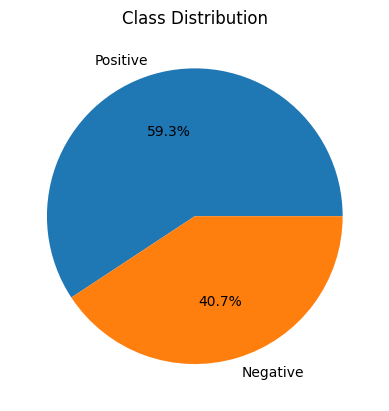

In [10]:
class_counts = df['sentiment'].value_counts()
class_percents = class_counts / class_counts.sum() * 100
# Plot the pie chart
plt.pie(class_percents, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.savefig("my_plot.png")
plt.show()

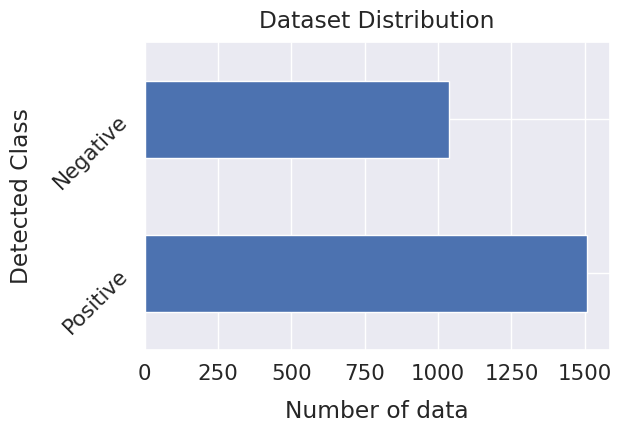

In [11]:
sns.set(font_scale=1.4)
df['sentiment'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of data", labelpad=12)
plt.ylabel("Detected Class", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);
plt.savefig("Dataset Distribution BarChart.png")

# **Data Preperation and Cleaning**

# **Removing Duplicate Rows**

In [12]:
df.drop_duplicates(inplace=True)

# **Stopwords Removal**

In [13]:
def process_conversations(Conversation): 
    stp = open('/content/drive/MyDrive/Ecommerce Sentiment Analysis/Code/stopwords-bn (1).txt','r',encoding="utf8").read().split()
    result = Conversation.split()
    Conversation = [word.strip() for word in result if word not in stp ]
    Conversation =" ".join(Conversation)
    Conversation = re.sub('[^\u0980-\u09FF]',' ',str(Conversation))
    return Conversation

In [14]:
df.dtypes

Comments     object
sentiment    object
dtype: object

In [15]:
df['cleaned'] = df['Comments'].apply(process_conversations)  
sample_data = [10,700]
for i in sample_data:
     print('Original:\n',df.Comments[i],'\nCleaned:\n',
           df.cleaned[i],'\n','Detected as:-- ',df.sentiment[i],'\n')

Original:
 এই পণ্য সম্পর্কে কোন সমস্যা নেই। 
Cleaned:
 পণ্য সম্পর্কে সমস্যা নেই  
 Detected as:--  Positive 

Original:
 মূল্যের সাথে সার্ভিসের সামাঞ্জস্য আছে। 
Cleaned:
 মূল্যের সাথে সার্ভিসের সামাঞ্জস্য আছে  
 Detected as:--  Positive 



In [16]:
df

,Comments,sentiment,cleaned
0,আমি মনে করি আমি আমার টাকা অপচয়,Negative,টাকা অপচয়
1,অবিশ্বাস্য মানের,Positive,অবিশ্বাস্য মানের
2,আপনার টাকা নষ্ট করবেন না,Negative,টাকা নষ্ট
3,আমাকে হতাশ করেনি,Positive,হতাশ করেনি
4,আমি আপনার কাছ থেকে নিষ্ক্রিয় পণ্য পেয়েছি যা ...,Negative,নিষ্ক্রিয় পণ্য পেয়েছি অপ্রত্যাশিত
...,...,...,...
2542,ভাল পণ্য,Positive,ভাল পণ্য
2543,"ভেক্টরগুলিতে ভাল, বিস্তারিত সম্পাদনাগুলিতে নিম...",Positive,ভেক্টরগুলিতে ভাল বিস্তারিত সম্পাদনাগুলিতে নিম...
2544,ফর্ম্যাটের কারণে প্রমাণ পর্যালোচনা করতে পারেনি...,Positive,ফর্ম্যাটের কারণে প্রমাণ পর্যালোচনা পারেনি তৃতী...
2545,অর্থ প্রদানের আগে যোগাযোগ দুর্দান্ত। শূন্য যোগ...,Positive,অর্থ প্রদানের যোগাযোগ দুর্দান্ত শূন্য যোগাযোগ...


# **Removing Small Texts**

In [17]:
df['length'] = df['cleaned'].apply(lambda x:len(x.split()))

dataset = df.loc[df.length>0]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small conversations".format(len(df)-len(dataset)),
      "\nTotal conversations:",len(dataset))

dataset['no_char'] = df['cleaned'].apply(lambda cleaned: len(cleaned))

After Cleaning: 
Removed 1 Small conversations 
Total conversations: 2518


In [18]:
dataset

,Comments,sentiment,cleaned,length,no_char
0,আমি মনে করি আমি আমার টাকা অপচয়,Negative,টাকা অপচয়,2,10.0
1,অবিশ্বাস্য মানের,Positive,অবিশ্বাস্য মানের,2,16.0
2,আপনার টাকা নষ্ট করবেন না,Negative,টাকা নষ্ট,2,9.0
3,আমাকে হতাশ করেনি,Positive,হতাশ করেনি,2,10.0
4,আমি আপনার কাছ থেকে নিষ্ক্রিয় পণ্য পেয়েছি যা ...,Negative,নিষ্ক্রিয় পণ্য পেয়েছি অপ্রত্যাশিত,4,35.0
...,...,...,...,...,...
2513,ভাল পণ্য,Positive,ভাল পণ্য,2,NaN
2514,"ভেক্টরগুলিতে ভাল, বিস্তারিত সম্পাদনাগুলিতে নিম...",Positive,ভেক্টরগুলিতে ভাল বিস্তারিত সম্পাদনাগুলিতে নিম...,6,62.0
2515,ফর্ম্যাটের কারণে প্রমাণ পর্যালোচনা করতে পারেনি...,Positive,ফর্ম্যাটের কারণে প্রমাণ পর্যালোচনা পারেনি তৃতী...,15,197.0
2516,অর্থ প্রদানের আগে যোগাযোগ দুর্দান্ত। শূন্য যোগ...,Positive,অর্থ প্রদানের যোগাযোগ দুর্দান্ত শূন্য যোগাযোগ...,36,18.0


# **Stemming**

In [19]:
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer
## stemmer function
def stem_text (x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
dataset.head()

,Comments,sentiment,cleaned,length,no_char
0,আমি মনে করি আমি আমার টাকা অপচয়,Negative,টাকা অপচয়,2,10.0
1,অবিশ্বাস্য মানের,Positive,অবিশ্বাস্য মানের,2,16.0
2,আপনার টাকা নষ্ট করবেন না,Negative,টাকা নষ্ট,2,9.0
3,আমাকে হতাশ করেনি,Positive,হতাশ করেনি,2,10.0
4,আমি আপনার কাছ থেকে নিষ্ক্রিয় পণ্য পেয়েছি যা ...,Negative,নিষ্ক্রিয় পণ্য পেয়েছি অপ্রত্যাশিত,4,35.0


In [21]:
dataset['stemming']=dataset['cleaned'].apply(stem_text)

Streaming output truncated to the last 5000 lines.
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..


In [22]:
dataset

,Comments,sentiment,cleaned,length,no_char,stemming
0,আমি মনে করি আমি আমার টাকা অপচয়,Negative,টাকা অপচয়,2,10.0,টাকা অপচয়
1,অবিশ্বাস্য মানের,Positive,অবিশ্বাস্য মানের,2,16.0,অবিশ্বাস্য মান
2,আপনার টাকা নষ্ট করবেন না,Negative,টাকা নষ্ট,2,9.0,টাকা নষ্ট
3,আমাকে হতাশ করেনি,Positive,হতাশ করেনি,2,10.0,হতাশ করেনি
4,আমি আপনার কাছ থেকে নিষ্ক্রিয় পণ্য পেয়েছি যা ...,Negative,নিষ্ক্রিয় পণ্য পেয়েছি অপ্রত্যাশিত,4,35.0,নিষ্ক্রিয় পণ্য পেয়ে অপ্রত্যাশিত
...,...,...,...,...,...,...
2513,ভাল পণ্য,Positive,ভাল পণ্য,2,NaN,ভাল পণ্য
2514,"ভেক্টরগুলিতে ভাল, বিস্তারিত সম্পাদনাগুলিতে নিম...",Positive,ভেক্টরগুলিতে ভাল বিস্তারিত সম্পাদনাগুলিতে নিম...,6,62.0,ভেক্টর ভাল বিস্তারিত সম্পাদনা নিম্ন মান
2515,ফর্ম্যাটের কারণে প্রমাণ পর্যালোচনা করতে পারেনি...,Positive,ফর্ম্যাটের কারণে প্রমাণ পর্যালোচনা পারেনি তৃতী...,15,197.0,ফর্ম্যাট কারণে প্রমাণ পর্যালোচনা পারেনি তৃতীয়...
2516,অর্থ প্রদানের আগে যোগাযোগ দুর্দান্ত। শূন্য যোগ...,Positive,অর্থ প্রদানের যোগাযোগ দুর্দান্ত শূন্য যোগাযোগ...,36,18.0,অর্থ প্রদান যোগাযোগ দুর্দান্ত শূন্য যোগাযোগ ক...


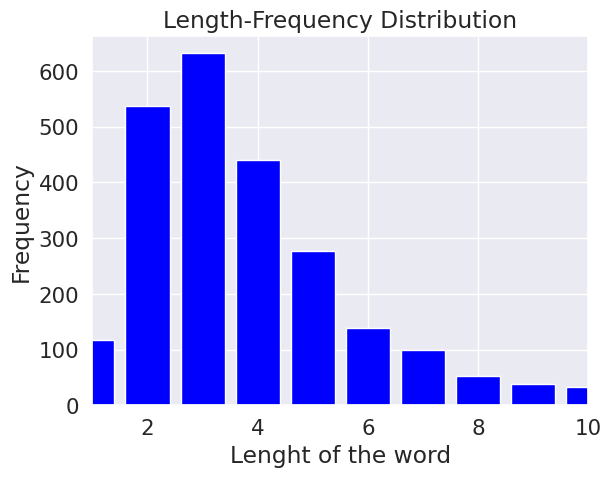

Maximum Length of a comment: 65
Minimum Length of a comment: 1
Average Length of a comment: 5.0


<Figure size 640x480 with 0 Axes>

In [23]:
frequency = dict()
for i in dataset.length:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="blue")
plt.xlim(1, 10)

plt.xlabel('Lenght of the word')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a comment: {max(dataset.length)}")
print(f"Minimum Length of a comment: {min(dataset.length)}")
print(f"Average Length of a comment: {round(np.mean(dataset.length),0)}")

plt.savefig("Length-Frequency Distribution Bangla BarChart.png")

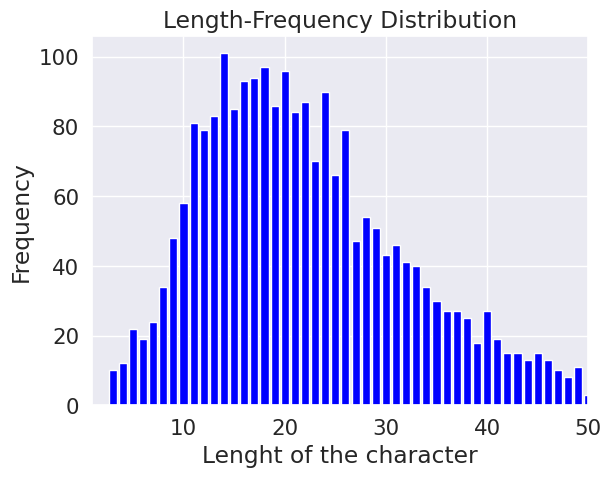

Maximum Length of a comment: 443.0
Minimum Length of a comment: 0.0
Average Length of a comment: 28.0


<Figure size 640x480 with 0 Axes>

In [24]:
frequency = dict()
for i in dataset.no_char:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="blue")
plt.xlim(1, 50)

plt.xlabel('Lenght of the character')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a comment: {max(dataset.no_char)}")
print(f"Minimum Length of a comment: {min(dataset.no_char)}")
print(f"Average Length of a comment: {round(np.mean(dataset.no_char),0)}")
plt.savefig("Character Frequency Distribution Bangla BarChart.png")

# **Data Set Summary**

In [25]:
def data_summary(dataset):
    documents = []
    words = []
    most_frequent_word =[]
    u_words = []
   
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.sentiment.value_counts().to_dict().items()]

    for label in class_label: 
        word_list = [word.strip().lower() for t in list(dataset[dataset.sentiment==label].cleaned) for word in t.strip().split()]
        
        counts = dict()
        
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
      
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    
        documents.append(len(list(dataset[dataset.sentiment==label].cleaned)))
        
        words.append(len(word_list))
         
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of comments:{}".format(len(list(dataset[dataset.sentiment==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:15]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))           
   
    return documents,words,u_words,class_label

documents,words,u_words,class_names = data_summary(dataset)


Class Name :  Positive
Number of comments:1481
Number of Words:6994
Number of Unique Words:1911
Most Frequent Words:

ভাল	283
ভালো	278
পণ্য	118
ধন্যবাদ	99
প্রোডাক্ট	98
সুন্দর	97
খুবই	82
দাম	81
মানের	77
অত্যন্ত	67
দামে	61
কম	60
ছিল	55
মান	54
অসাধারণ	52

Class Name :  Negative
Number of comments:1036
Number of Words:4381
Number of Unique Words:1594
Most Frequent Words:

না	115
খারাপ	83
বাজে	73
পণ্য	67
মানের	64
ভাল	63
ভালো	61
প্রোডাক্ট	61
কোয়ালিটি	54
ফালতু	45
একটা	43
সাথে	41
খুবই	39
দারাজ	38
টা	36
Total Number of Unique Words:2844


***New Dataframe for Data Summary***

In [26]:
data_matrix = pd.DataFrame({'Total comments':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
data = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")

In [27]:
data

,Class Names,Category,Values
0,Positive,Total comments,1481
1,Negative,Total comments,1036
2,Positive,Total Words,6994
3,Negative,Total Words,4381
4,Positive,Unique Words,1911
5,Negative,Unique Words,1594


***Data Summary Visualization***

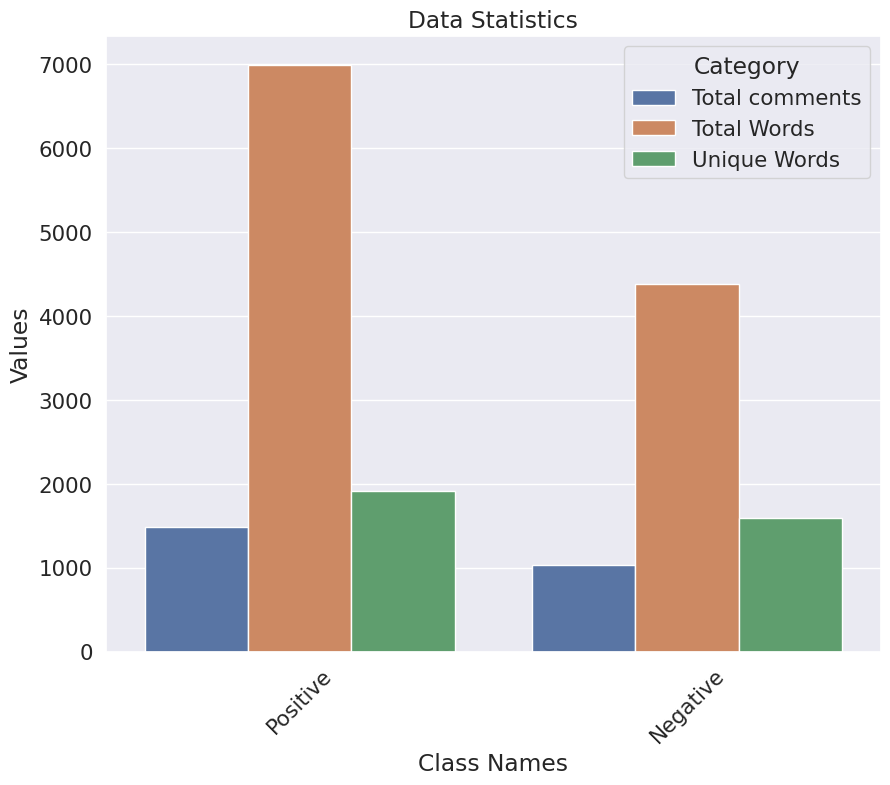

In [28]:
plt.figure(figsize=(10, 8))
ax = plt.subplot()

sns.barplot(data=data,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names') 
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

plt.savefig("Data Statistics Bangla BarChart.png")

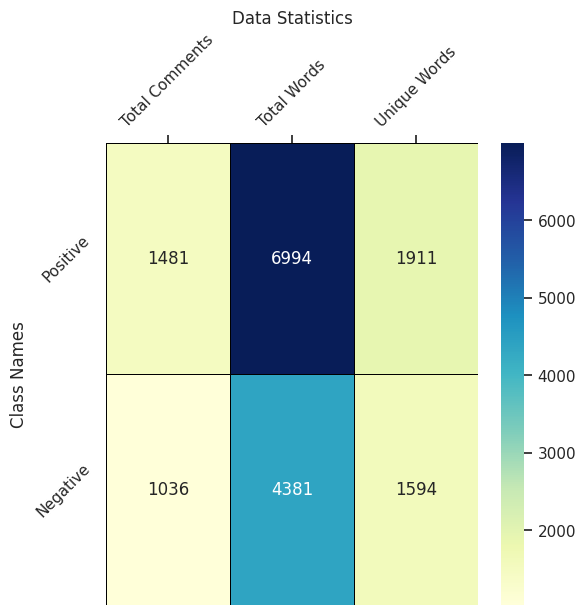

In [29]:
sns.set()
plt.figure(figsize =(6, 6))
ax = plt.subplot()
sns.heatmap(data_matrix.iloc[:,0:3], annot=True,fmt="d", linewidths=0.5,linecolor = 'Black',cmap = "YlGnBu",ax = ax)

ax.set_ylabel('Class Names') 
ax.set_title('Data Statistics')
y_label = ["Total Comments", "Total Words", "Unique Words"] 
ax.xaxis.set_ticklabels(y_label, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
ax.xaxis.tick_top()
plt.savefig("Data Statistics Bangla.png")

## **Label Encoding Function**

In [30]:
def label_encoding(sentiment,bool):
  
    le = LabelEncoder()
    le.fit(sentiment)
    encoded_labels = le.transform(sentiment)
    labels = np.array(encoded_labels)
    class_names =le.classes_
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(sentiment[i],' ', encoded_labels[i],'\n')

    return labels
    

# **Dataset Splitting Function**

In [31]:
def dataset_split(feature_space,sentiment):

    X_train,X_test,y_train,y_test = train_test_split(feature_space,sentiment,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print("Feature Size :======>",X_train.shape[1])
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",feature_space.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0])
  
    return X_train,X_test,y_train,y_test

In [32]:
dataset.cleaned = dataset.stemming.apply(lambda x:x.replace('\n',' '))

In [33]:
dataset

,Comments,sentiment,cleaned,length,no_char,stemming
0,আমি মনে করি আমি আমার টাকা অপচয়,Negative,টাকা অপচয়,2,10.0,টাকা অপচয়
1,অবিশ্বাস্য মানের,Positive,অবিশ্বাস্য মান,2,16.0,অবিশ্বাস্য মান
2,আপনার টাকা নষ্ট করবেন না,Negative,টাকা নষ্ট,2,9.0,টাকা নষ্ট
3,আমাকে হতাশ করেনি,Positive,হতাশ করেনি,2,10.0,হতাশ করেনি
4,আমি আপনার কাছ থেকে নিষ্ক্রিয় পণ্য পেয়েছি যা ...,Negative,নিষ্ক্রিয় পণ্য পেয়ে অপ্রত্যাশিত,4,35.0,নিষ্ক্রিয় পণ্য পেয়ে অপ্রত্যাশিত
...,...,...,...,...,...,...
2513,ভাল পণ্য,Positive,ভাল পণ্য,2,NaN,ভাল পণ্য
2514,"ভেক্টরগুলিতে ভাল, বিস্তারিত সম্পাদনাগুলিতে নিম...",Positive,ভেক্টর ভাল বিস্তারিত সম্পাদনা নিম্ন মান,6,62.0,ভেক্টর ভাল বিস্তারিত সম্পাদনা নিম্ন মান
2515,ফর্ম্যাটের কারণে প্রমাণ পর্যালোচনা করতে পারেনি...,Positive,ফর্ম্যাট কারণে প্রমাণ পর্যালোচনা পারেনি তৃতীয়...,15,197.0,ফর্ম্যাট কারণে প্রমাণ পর্যালোচনা পারেনি তৃতীয়...
2516,অর্থ প্রদানের আগে যোগাযোগ দুর্দান্ত। শূন্য যোগ...,Positive,অর্থ প্রদান যোগাযোগ দুর্দান্ত শূন্য যোগাযোগ ক...,36,18.0,অর্থ প্রদান যোগাযোগ দুর্দান্ত শূন্য যোগাযোগ ক...


In [34]:
dataset=dataset.drop(["Comments","cleaned","length","no_char"],axis=1)

In [35]:
dataset.head()

,sentiment,stemming
0,Negative,টাকা অপচয়
1,Positive,অবিশ্বাস্য মান
2,Negative,টাকা নষ্ট
3,Positive,হতাশ করেনি
4,Negative,নিষ্ক্রিয় পণ্য পেয়ে অপ্রত্যাশিত


# ***Unigram Tf-idf value calculation***

In [36]:
def calc_gram_tfidf(Conversations):
    tfidf = TfidfVectorizer(ngram_range=(1,3),use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(Conversations)
    
    return tfidf,X

# **Unigram**

In [37]:
x = ["আমি মনে করি আমি আমার টাকা অপচয়"]

def get_top_n_words(x, n):
    vec = CountVectorizer().fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

get_top_n_words(x,3)

[('আম', 3), ('মন', 1), ('কর', 1)]

# **Bigram**

In [38]:
y = ["আমি মনে করি আমি আমার টাকা অপচয়"]
def get_top_n_words(x, n):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]
get_top_n_words(y,3)

[('আম মন', 1), ('মন কর', 1), ('কর আম', 1)]

# **Tigram**

In [39]:
z = ["আমি মনে করি আমি আমার টাকা অপচয়"]
def get_top_n_words(x, n):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]
get_top_n_words(z,3)

[('আম মন কর', 1), ('মন কর আম', 1), ('কর আম আম', 1)]

In [40]:
import warnings
warnings.filterwarnings("ignore")

In [42]:
# gram_names = ['Unigram','Bigram','Trigram']
# ngrams = [(1,1),(1,2),(1,3)]

# for i,gram in enumerate(ngrams):
#      tfidf,feature = calc_gram_tfidf(dataset.stemming)
#      labels = label_encoding(dataset.sentiment,False)
#      X_train,X_test,y_train,y_test = dataset_split(feature,labels) 
#      ml_models,model_names = ml_models_defination()
#      accuracy = {f'{model_names[j]}': model_performance(model, X_train, X_test, y_train, y_test) for j, model in enumerate(ml_models)}

#      with open(f'ml_performance_{gram_names[i]}.json', 'w') as f:
#            json.dump(accuracy,f)

# **Tokenization**

In [43]:
max_fatures = 500
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(dataset['stemming'].values)
X = tokenizer.texts_to_sequences(dataset['stemming'].values)
X = pad_sequences(X)

In [44]:
X

array([[  0,   0,   0, ...,   0,  37, 251],
       [  0,   0,   0, ...,   0, 287,   4],
       [  0,   0,   0, ...,   0,  37,  54],
       ...,
       [  0,   0,   0, ..., 198, 334, 285],
       [  0,   0,   0, ..., 484, 370,  91],
       [  0,   0,   0, ...,   0, 320, 245]], dtype=int32)

In [45]:
np.shape(X)

(2518, 48)

# **Model Creation**

# **LSTM**

In [46]:
X.shape

(2518, 48)

In [47]:
embed_dim = 64
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
#model.add(SpatialDropout1D(0.4))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(256,activation='softmax'))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 64)            32000     
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 82,178
Trainable params: 82,178
Non-trainable params: 0
_________________________________________________________________


In [48]:
Y = pd.get_dummies(dataset['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2,random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2014, 48) (2014, 2)
(504, 48) (504, 2)


In [49]:
history=model.fit(X_train, Y_train, epochs = 50, batch_size=32, verbose = 1,validation_data=(X_test,Y_test))

Epoch 1/50
63/63 [==============================] - 8s 77ms/step - loss: 0.6871 - accuracy: 0.5899 - val_loss: 0.6855 - val_accuracy: 0.5655
Epoch 2/50
63/63 [==============================] - 6s 95ms/step - loss: 0.6782 - accuracy: 0.5938 - val_loss: 0.6846 - val_accuracy: 0.5655
Epoch 3/50
63/63 [==============================] - 4s 68ms/step - loss: 0.6761 - accuracy: 0.5938 - val_loss: 0.6848 - val_accuracy: 0.5655
Epoch 4/50
63/63 [==============================] - 5s 79ms/step - loss: 0.6700 - accuracy: 0.5938 - val_loss: 0.6615 - val_accuracy: 0.5655
Epoch 5/50
63/63 [==============================] - 5s 87ms/step - loss: 0.6286 - accuracy: 0.5938 - val_loss: 0.6143 - val_accuracy: 0.5655
Epoch 6/50
63/63 [==============================] - 4s 68ms/step - loss: 0.5803 - accuracy: 0.7830 - val_loss: 0.5711 - val_accuracy: 0.8353
Epoch 7/50
63/63 [==============================] - 5s 83ms/step - loss: 0.5392 - accuracy: 0.8525 - val_loss: 0.5343 - val_accuracy: 0.8452
Epoch 8/50
63

In [50]:
import tensorflow as tf

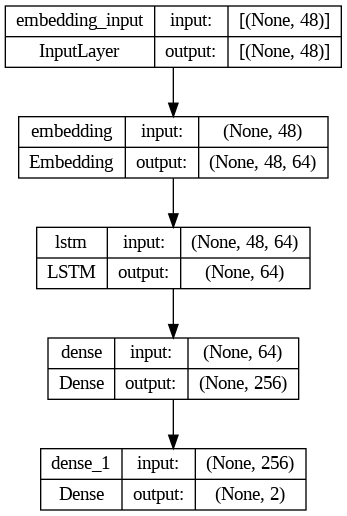

In [51]:
tf.keras.utils.plot_model(model, show_shapes=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-w3old2dl
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-w3old2dl
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 19.4 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13719 sha256=0b5a3dad8c160809b24551f0f5ced00ff1052b0123fbdc387a7c1dcda1b616bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-fbq8rw5k/wheels/89/d3/c2/937382b33c09192fc84331bbc02c4565d62aeae67e9684c37e
Successfully built visualkeras


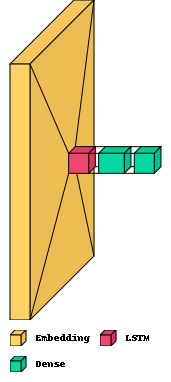

In [52]:
from tensorflow.keras.models import Model
!pip install git+https://github.com/paulgavrikov/visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True) 

# **Evaluation**

In [53]:
score = model.evaluate(X_train, Y_train,batch_size=64, verbose=2)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

32/32 - 0s - loss: 0.2589 - accuracy: 0.9086 - 382ms/epoch - 12ms/step
Train loss: 0.2589036524295807
Train accuracy: 0.9086395502090454


In [54]:
score = model.evaluate(X_test, Y_test,batch_size=64, verbose=2)
print('Test loss:', score[0])
acc=score[1]
print('Test accuracy:', acc)


8/8 - 0s - loss: 0.4517 - accuracy: 0.8333 - 118ms/epoch - 15ms/step
Test loss: 0.45166587829589844
Test accuracy: 0.8333333134651184


# **Learning Curve**

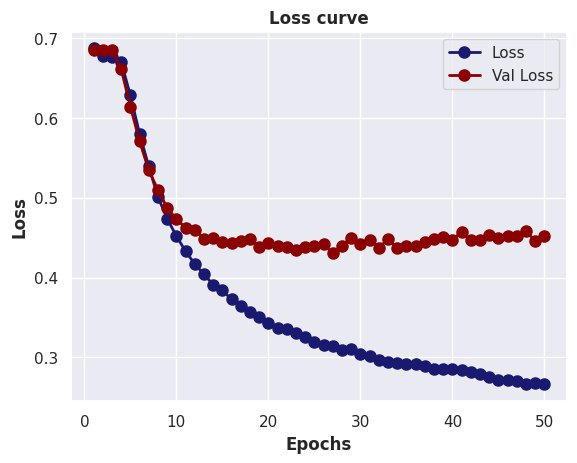

In [55]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')


plt.plot(epochs, loss_values, color='midnightblue', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_loss_values, color='darkred', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Loss curve',fontsize=12,fontweight='bold')
plt.xlabel('Epochs',fontsize=12,fontweight='bold')
plt.ylabel('Loss',fontsize=12,fontweight='bold')
plt.legend(['Loss','Val Loss'])
                  

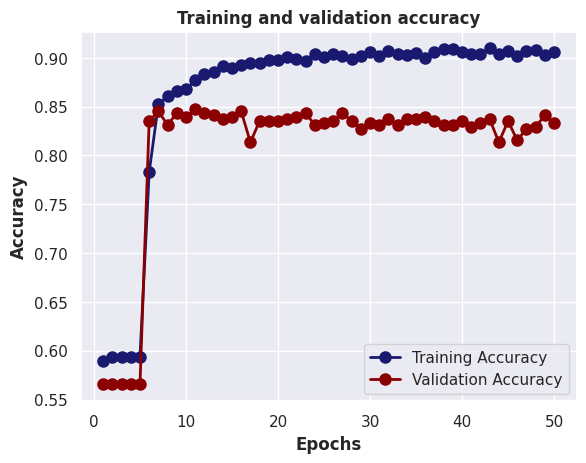

In [56]:
plt.plot(epochs, acc, color='midnightblue', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_acc, color='darkred', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Training and validation accuracy',fontsize=12,fontweight='bold')
plt.xlabel('Epochs',fontsize=12,fontweight='bold')
plt.ylabel('Accuracy',fontsize=12,fontweight='bold')
plt.legend(['Training Accuracy','Validation Accuracy'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


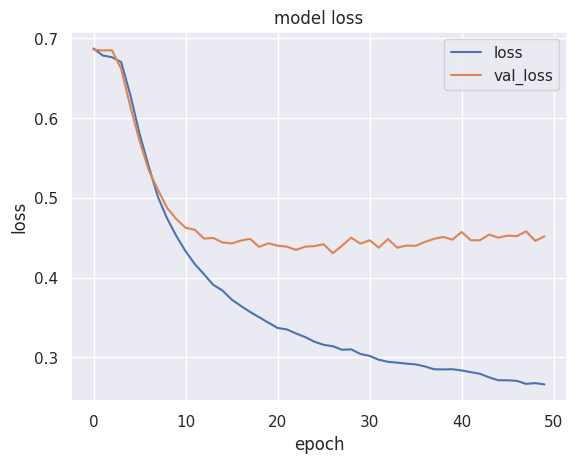

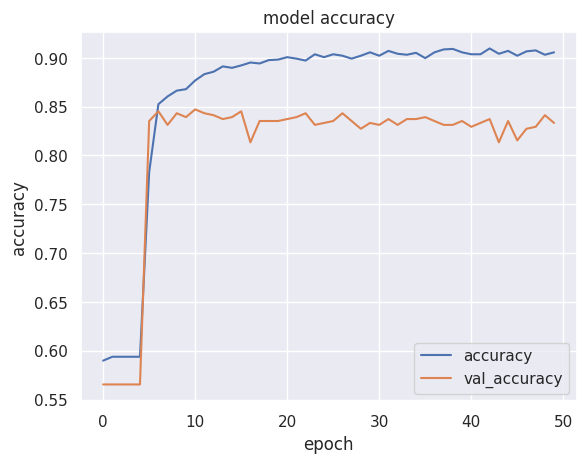

In [57]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

### **Confusion Matrix & Classification Report**

In [58]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((2014, 48), (2014, 2), (504, 48), (504, 2))

In [59]:
y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(Y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

16/16 [==============================] - 0s 10ms/step
[[181  38]
 [ 46 239]]


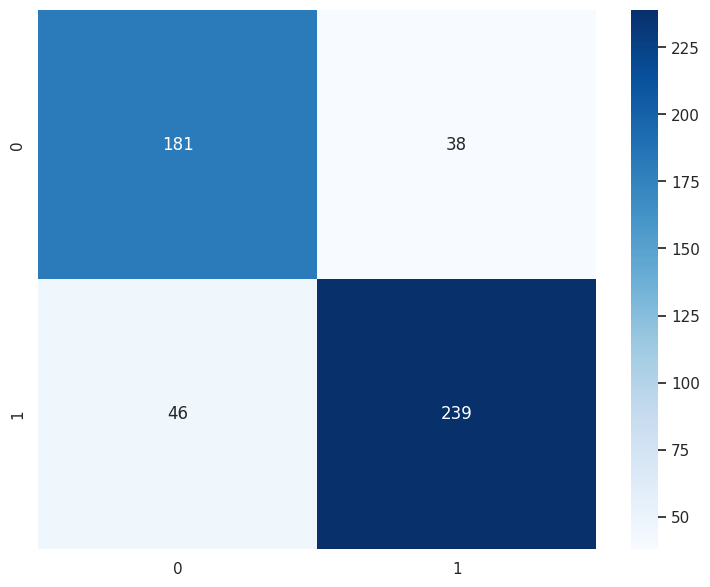

In [60]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(cm,cmap='Blues', annot=True,fmt='d')
plt.show()


In [61]:
# print(classification_report(y_test, y_pred))

In [63]:
from sklearn.metrics import classification_report

In [65]:
report = pd.DataFrame(classification_report(y_test, y_pred,output_dict=True)).transpose()

In [66]:
report = report.rename(index={'0': 'Positive','1':'Negative'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))

In [67]:
report

,precision,recall,f1-score,support
Positive,79.74,82.65,81.17,219.000000
Negative,86.28,83.86,85.05,285.000000
accuracy,83.33,83.33,83.33,0.833333
macro avg,83.01,83.25,83.11,504.000000
weighted avg,83.44,83.33,83.36,504.000000


In [68]:
twt = ['এটা সম্পূর্ণ আবর্জনা।']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("Positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0 133  97]]
1/1 - 0s - 265ms/epoch - 265ms/step
negative
